In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

%matplotlib notebook

In [2]:
import factorization_machine as fm
import util
import imp

In [3]:
df_train = pd.read_csv('../data/ml-100k/ua.base', header=None, names=['uid', 'sid', 'score', 'ts'], sep='\t')

In [4]:
df_test = pd.read_csv('../data/ml-100k/ua.test', header=None, names=['uid', 'sid', 'score', 'ts'], sep='\t')

In [68]:
df_test.head()

,uid,sid,score,ts
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201


In [6]:
!wc -l ../data/ml-100k/ua.base

   90570 ../data/ml-100k/ua.base


In [7]:
!wc -l ../data/ml-100k/ua.test

    9430 ../data/ml-100k/ua.test


In [8]:
### MF
#X_base, Y_base = util.load_dataset_mf('../data/ml-100k/ua.base', user_cnt=943, item_cnt=1682, entry_cnt=90570)
#X_test, Y_test = util.load_dataset_mf('../data/ml-100k/ua.test', user_cnt=943, item_cnt=1682, entry_cnt=9430)

In [73]:
util = imp.reload(util)
### SVD++
X_base, Y_base = util.load_dataset_svd('../data/ml-100k/ua.base', user_cnt=943, item_cnt=1682, entry_cnt=90570)
X_test, Y_test = util.load_dataset_svd('../data/ml-100k/ua.test', user_cnt=943, item_cnt=1682, entry_cnt=9430)

In [9]:
### Alternative Least Square Regression

In [74]:
X_train, X_dev, y_train, y_dev = train_test_split(X_base, Y_base)
y_test = Y_test

<IPython.core.display.Javascript object>


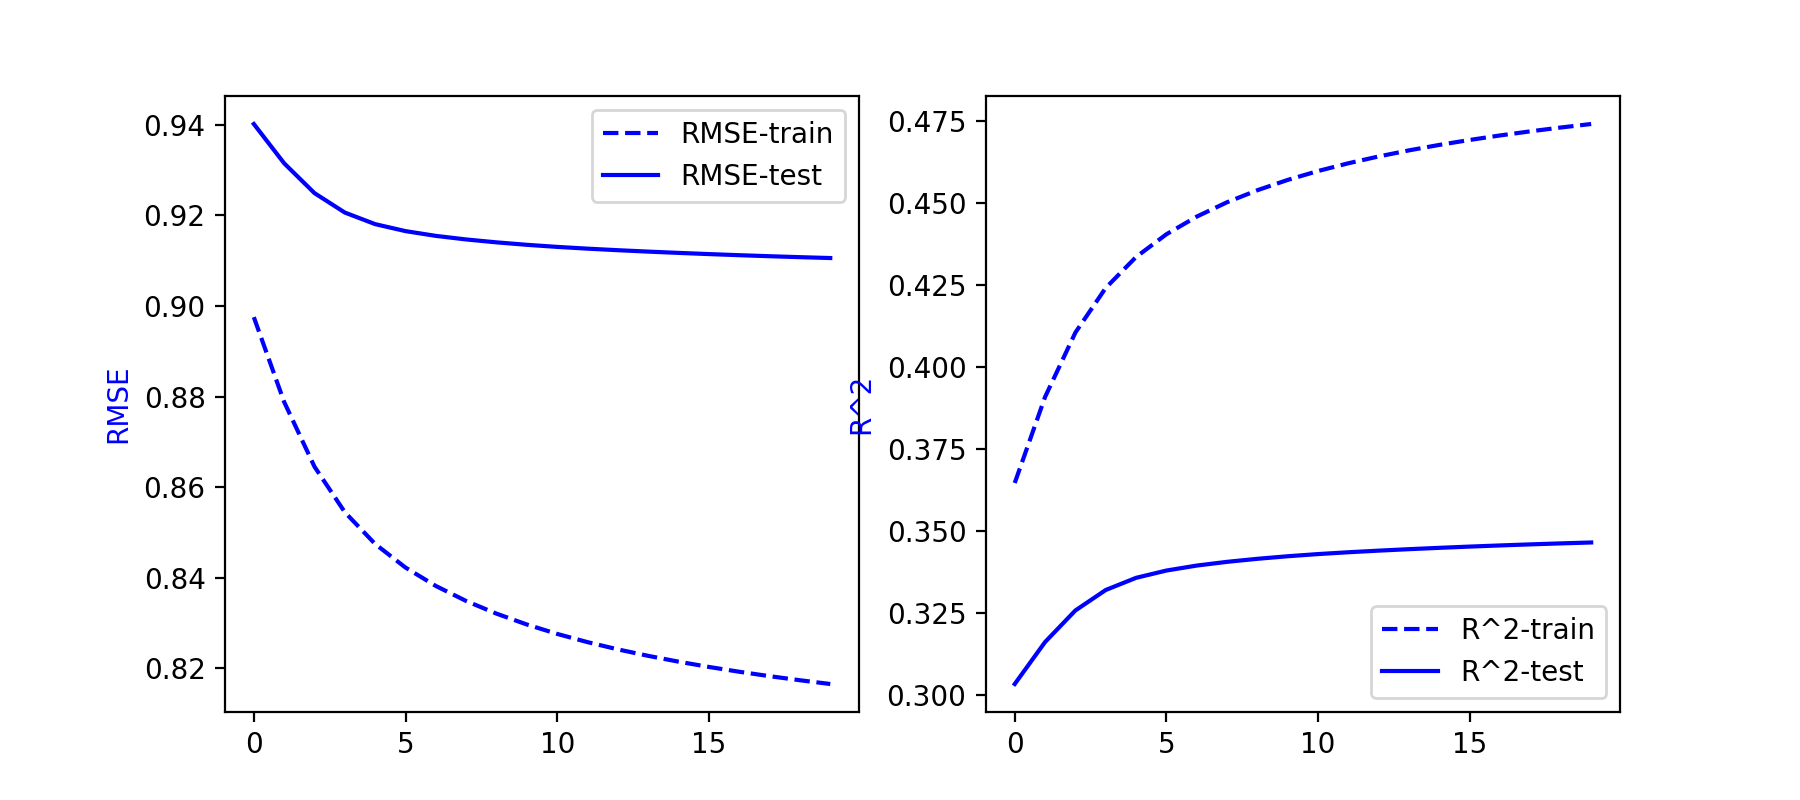

In [75]:
fm = imp.reload(fm)
model = fm.create_model(alg="als", type="regression", n_iter=0, init_stdev=0.1, l2_reg_w=2.1,
                          l2_reg_V=20.1, rank=5, step_size=0.01)
fm.train(model, X_train, y_train, X_dev, y_dev, alg="als", type="regression",
         epoch=20, step_size=1, trace_graph=True)

In [12]:
ytr = util.evaluate_regression(model, X_train, y_train)
print(list(zip(ytr[:5], y_train[:5])))
yde = util.evaluate_regression(model, X_dev, y_dev)
print(list(zip(yde[:5], y_dev[:5])))
yte = util.evaluate_regression(model, X_test, Y_test)
print(list(zip(yte[:5], y_test[:5])))

mse: 0.757596308035189
r2 : 0.4044714904585601
[(3.563027093586467, 1.0), (3.7245133741657086, 3.0), (2.1992359361657448, 2.0), (4.155113189576753, 4.0), (4.73241139081854, 5.0)]
mse: 0.8463628714234305
r2 : 0.32596074853907053
[(4.103271464214454, 4.0), (2.8640504361054364, 3.0), (2.0569704769334147, 1.0), (3.8196876510535382, 4.0), (2.9160658912318596, 4.0)]
mse: 0.9108800714531327
r2 : 0.27408551110378565
[(3.496894132811386, 4.0), (3.464664307472492, 4.0), (3.926864148105093, 4.0), (3.632406426828161, 3.0), (2.6781427145252077, 2.0)]


In [76]:
### Alternative Least Square Classification

In [77]:
y_base = np.ones_like(Y_base)
y_test = np.ones_like(Y_test)
y_base[Y_base < np.mean(Y_base)] = 0
y_base[Y_base >= np.mean(Y_base)] = 1
y_test[Y_test < np.mean(Y_test)] = 0
y_test[Y_test >= np.mean(Y_base)] = 1
X_train, X_dev, y_train, y_dev = train_test_split(X_base.tocsr(), y_base)

In [78]:
# check balance
print('threshold', np.mean(Y_base))
print(np.count_nonzero(y_train)/len(y_train))
print(np.count_nonzero(y_dev)/len(y_dev))
print(np.count_nonzero(y_test)/len(y_test))
# set up negative labels
y_train[y_train == 0] = -1
y_dev[y_dev == 0] = -1
y_test[y_test == 0] = -1

threshold 3.5238268
0.5519454708731433
0.5482489069469594
0.5799575821845175


<IPython.core.display.Javascript object>


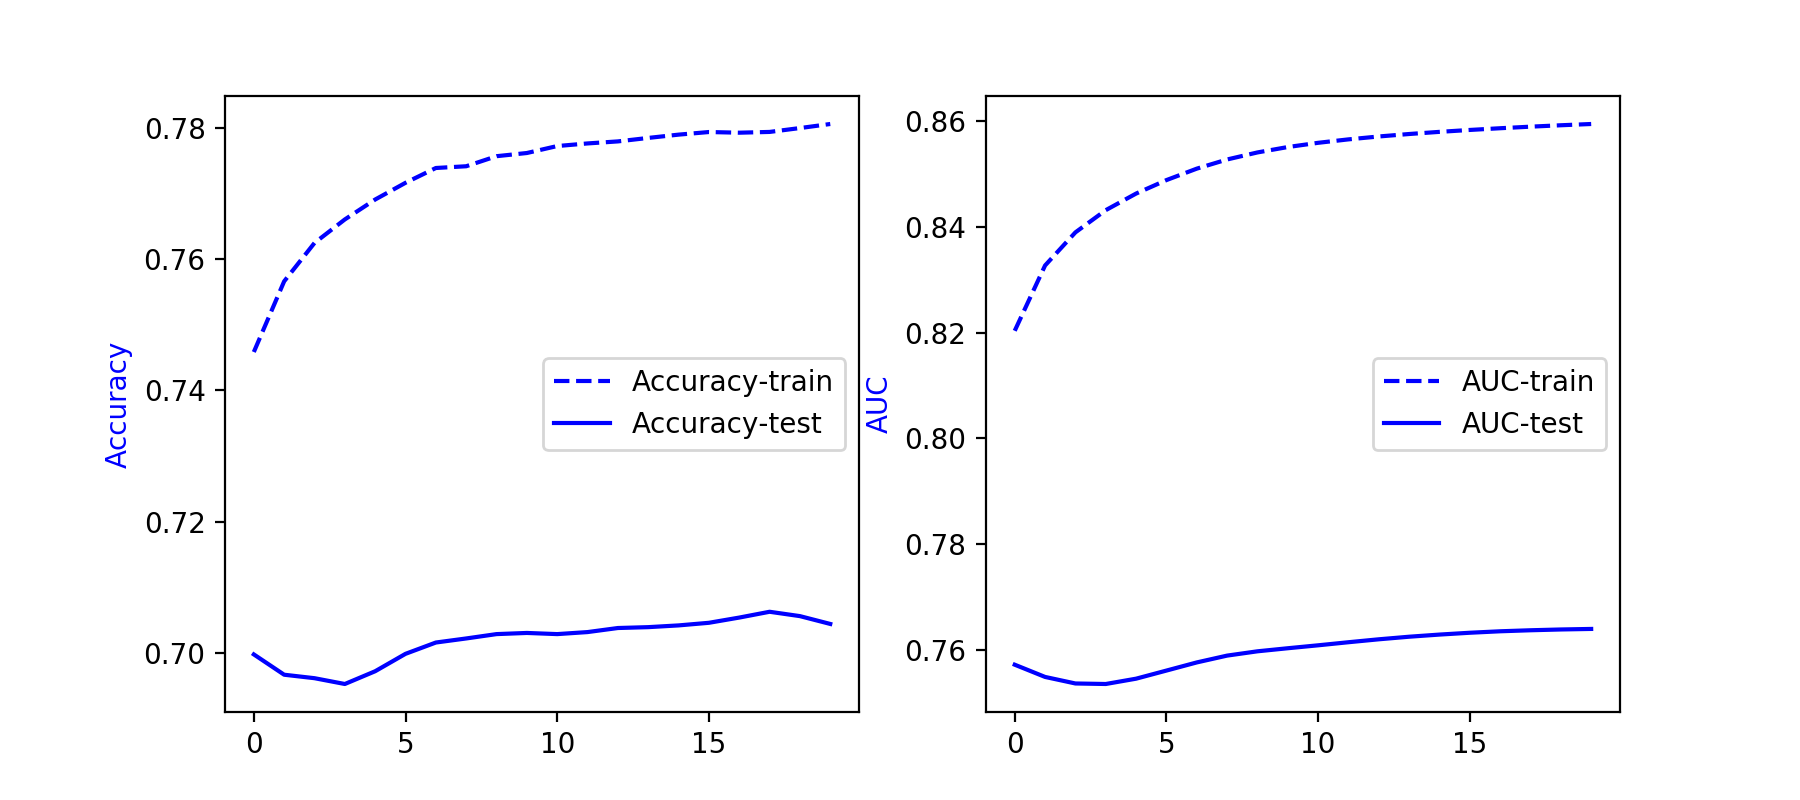

In [79]:
fm = imp.reload(fm)
model = fm.create_model(alg="als", type="classification", n_iter=0, init_stdev=0.1, l2_reg_w=0.1,
                          l2_reg_V=0.1, rank=2, step_size=0.1)
fm.train(model, X_train, y_train, X_dev, y_dev, alg="als", type="classification",
         epoch=20, step_size=1, trace_graph=True)

In [80]:
ytr = util.evaluate_classification(model, X_train, y_train)
print(list(zip(ytr[:5], y_train[:5])))
yde = util.evaluate_classification(model, X_dev, y_dev)
print(list(zip(yde[:5], y_dev[:5])))
yte = util.evaluate_classification(model, X_test, y_test)
print(list(zip(yte[:5], y_test[:5])))

acc: 0.7805732624729489
auc: 0.8594357990719965
[(0.671732908187316, -1.0), (0.6008013226665911, -1.0), (0.4504614035047601, -1.0), (0.2706860214729184, -1.0), (0.47603946913243317, 1.0)]
acc: 0.7044561233052158
auc: 0.7639545703534067
[(0.16999536179229824, -1.0), (0.72273361422478, 1.0), (0.5888528811382762, 1.0), (0.5910302487026576, 1.0), (0.39745379207125453, -1.0)]
acc: 0.6242841993637328
auc: 0.6566611775101627
[(0.4292865193238393, 1.0), (0.4520170949196356, 1.0), (0.5024580383232187, 1.0), (0.6598481498878896, -1.0), (0.48960661191178, -1.0)]
